In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme()

In [44]:
df_ba_beers     = pd.read_csv('data/beer_advocate/beers.csv')
df_ba_breweries = pd.read_csv('data/beer_advocate/breweries.csv')
df_ba_users     = pd.read_csv('data/beer_advocate/users.csv')
df_ba_ratings   = pd.read_csv('data/beer_advocate/ratings.csv')

In [4]:
def format_timestamp(ts) -> str:
    return str(pd.to_datetime(ts, unit='s'))

In [48]:
df_ba_ratings = df_ba_ratings.merge(df_ba_beers[['beer_id', 'beer_style']], how='left', on='beer_id')
df_ba_ratings = df_ba_ratings.merge(df_ba_users[['user_id', 'user_created_date']], how='left', on='user_id')

In [ ]:
df_ba_ratings = df_ba_ratings.sort_values(['user_id', 'date'])
df_ba_ratings['overall_past_ratings_count']   = df_ba_ratings.groupby('user_id').cumcount()
df_ba_ratings['overall_past_ratings_average'] = df_ba_ratings.groupby('user_id')['rating'].expanding().mean().shift().reset_index(level=0, drop=True)
df_ba_ratings.loc[df_ba_ratings["overall_past_ratings_count"] == 0, "overall_past_ratings_average"] = np.nan

df_ba_ratings = df_ba_ratings.sort_values(['user_id', 'beer_style', 'date'])
df_ba_ratings['style_past_ratings_count']   = df_ba_ratings.groupby(['user_id', 'beer_style']).cumcount()
df_ba_ratings['style_past_ratings_average'] = df_ba_ratings.groupby(['user_id', 'beer_style'])['rating'].expanding().mean().shift().reset_index(level=[0, 1], drop=True)
df_ba_ratings.loc[df_ba_ratings["style_past_ratings_count"] == 0, "style_past_ratings_average"] = np.nan

df_ba_ratings = df_ba_ratings.sort_values(['beer_id', 'date'])
df_ba_ratings['beer_past_ratings_count']   = df_ba_ratings.groupby('beer_id').cumcount()
df_ba_ratings['beer_past_ratings_average'] = df_ba_ratings.groupby('beer_id')['rating'].expanding().mean().shift().reset_index(level=0, drop=True)
df_ba_ratings.loc[df_ba_ratings["beer_past_ratings_count"] == 0, "beer_past_ratings_average"] = np.nan

In [6]:
BEER_MAPPING = {"Bock":["Bock","Doppelbock","Eisbock","Maibock / Helles Bock","Weizenbock"],
                "Brown Ale":["Altbier","American Brown Ale","Belgian Dark Ale","English Brown Ale","English Dark Mild Ale"],
                "Dark Ales":["Dubbel","Roggenbier","Scottish Ale","Winter Warmer","American Black Ale","Belgian Strong Dark Ale"],
                "Dark Lager":["American Amber / Red Lager","Czech Amber Lager","Czech Dark Lager","Euro Dark Lager","Märzen / Oktoberfest","Munich Dunkel Lager","Rauchbier","Schwarzbier","Vienna Lager"],
                "Hybrid Beer":["Bière de Champagne / Bière Brut","Braggot","California Common / Steam Beer","Cream Ale"],
                "India Pale Ale":["American IPA","Belgian IPA","Black IPA","Brut IPA","English India Pale Ale (IPA)","American Double / Imperial IPA","Milkshake IPA","New England IPA"],
                "Pale Ale":["Belgian Strong Pale Ale","American Amber / Red Ale","American Blonde Ale","American Pale Ale (APA)","Belgian Blonde Ale","Belgian Pale Ale","Bière de Garde","English Bitter","English Pale Ale","English Pale Mild Ale","Extra Special / Strong Bitter (ESB)","Grisette","Irish Red Ale","Kölsch","Saison / Farmhouse Ale"],
                "Pale Lager":["American Adjunct Lager","American Pale Lager","Czech Pilsener","Dortmunder / Export Lager","Euro Pale Lager","Euro Strong Lager","Festbier / Wiesnbier","German Pilsener","Munich Helles Lager","American Double / Imperial Pilsner","India Pale Lager (IPL)","Kellerbier / Zwickelbier","Light Lager","American Malt Liquor"],
                "Porter":["American Porter","Baltic Porter","English Porter","Imperial Porter","Robust Porter","Smoked Porter"],
                "Speciality Beer":["Black & Tan","Chile Beer","Fruit / Vegetable Beer","Scottish Gruit / Ancient Herbed Ale","Herbed / Spiced Beer","Happoshu","Herb and Spice Beer","Japanese Rice Lager","Kvass","Low-Alcohol Beer","Pumpkin Ale","Rye Beer","Sahti","Smoked Beer"],
                "Stout":["American Double / Imperial Stout","American Stout","English Stout","Foreign / Export Stout","Irish Dry Stout","Oatmeal Stout","Russian Imperial Stout","Milk / Sweet Stout"],
                "Strong Ale":["American Barleywine","American Strong Ale","Belgian Dark Strong Ale","Belgian Pale Strong Ale","English Barleywine","English Strong Ale","Imperial Red Ale","Old Ale","Quadrupel (Quad)","Scotch Ale / Wee Heavy","Tripel","Wheatwine"],
                "Wheat Beer":["American Dark Wheat Ale","American Pale Wheat Ale","Dunkelweizen","Grodziskie","Hefeweizen","Kristalweizen","Witbier"],
                "Wild/Sour Beer":["Berliner Weissbier","Brett Beer","Faro","Flanders Oud Bruin","Flanders Red Ale","Fruit Lambic","Fruited Kettle Sour","Gose","Gueuze","Lambic - Fruit", "Lambic - Unblended","American Wild Ale"],
                "Low Alcohol Beer":["Low Alcohol Beer"]}

In [7]:
df_beer_styles = pd.DataFrame([(style, sub_style) for style, sub_styles in BEER_MAPPING.items() for sub_style in sub_styles],
                              columns=["beer_global_style", "beer_style"])

In [8]:
df_ba_beers = df_ba_beers.merge(df_beer_styles, on = "beer_style", how="left")

# Analyses Répétitives

## Influence des ratings passés

Premières analyses rapides pour évaluer si intérêt à garder l'idée : 
 - correlation entre note donnée et moyenne des notes des bières précédentes pour chaque user
 - correlation entre note donnée et moyenne des notes des bières précédentes de même style pour chaque user
 - correlation entre note donnée et moyenne des notes précédentes pour la même bière par les autres users 
 - regression linéaire entre la note données et les différentes features que sont les moyennes passées aux différents styles de bières et la moyenne passée de la bière notée

In [79]:
users_with_enough_overall = df_ba_ratings[df_ba_ratings["overall_past_ratings_count"] >= 10]["user_id"].unique()
df_with_previous_ratings_overall = df_ba_ratings[(~df_ba_ratings["overall_past_ratings_average"].isna()) & (df_ba_ratings["user_id"].isin(users_with_enough_overall))]

users_with_enough_style = df_ba_ratings[df_ba_ratings["overall_past_ratings_count"] >= 10]["user_id"].unique()
df_with_previous_ratings_style = df_ba_ratings[(~df_ba_ratings["style_past_ratings_average"].isna()) & (df_ba_ratings["user_id"].isin(users_with_enough_style))]

df_with_previous_ratings_beers = df_ba_ratings[(~df_ba_ratings["beer_past_ratings_average"].isna()) & (df_ba_ratings["user_id"].isin(users_with_enough_overall))]

In [88]:
correlation_with_previous = df_with_previous_ratings_overall["rating"].corr(df_with_previous_ratings_overall["overall_past_ratings_average"])
correlation_with_previous_per_user = df_with_previous_ratings_overall.groupby('user_id').apply(lambda group: group['rating'].corr(group['overall_past_ratings_average']))

/Users/martinlebras/miniconda3/envs/ada_project/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/martinlebras/miniconda3/envs/ada_project/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_64046/2278153731.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_with_previous_per_user = df_with_previous_ratings_overall.groupby('user_id').apply(lambda group: group['rating'].corr(group['overall_past_ratings_average']))


In [89]:
correlation_with_previous

np.float64(0.4000502428183224)

In [81]:
correlation_with_previous_style = df_with_previous_ratings_style["rating"].corr(df_with_previous_ratings_style["overall_past_ratings_average"])
correlation_with_previous_per_user = df_with_previous_ratings_style.groupby('user_id').apply(lambda group: group['rating'].corr(group['overall_past_ratings_average']))

/Users/martinlebras/miniconda3/envs/ada_project/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2991: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/martinlebras/miniconda3/envs/ada_project/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/martinlebras/miniconda3/envs/ada_project/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/martinlebras/miniconda3/envs/ada_project/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/martinlebras/miniconda3/envs/ada_project/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/n

In [84]:
correlation_with_previous_style

np.float64(0.4304896720197668)

In [85]:
correlation_with_previous_users = df_with_previous_ratings_beers["rating"].corr(df_with_previous_ratings_overall["beer_past_ratings_average"])
correlation_with_previous_per_user = df_with_previous_ratings_beers.groupby('user_id').apply(lambda group: group['rating'].corr(group['beer_past_ratings_average']))

/Users/martinlebras/miniconda3/envs/ada_project/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/martinlebras/miniconda3/envs/ada_project/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_64046/1116863041.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_with_previous_per_user = df_with_previous_ratings_beers.groupby('user_id').apply(lambda group: group['rating'].corr(group['beer_past_ratings_average']))


In [86]:
correlation_with_previous_users

np.float64(0.6726770272139964)

## Exploration de la diversité des bières

In [312]:
most_active_user = df_ba_users.sort_values(by="user_ratings_count",ascending=False).iloc[0,2]

In [314]:
df_ba_ratings_most_active_user = df_ba_ratings[df_ba_ratings["user_id"] == most_active_user]

In [323]:
df_ba_ratings_most_active_user = df_ba_ratings_most_active_user[["user_id","beer_id","brewery_id"]].merge(df_ba_beers[["beer_id","beer_style","beer_global_style","beer_name"]],on="beer_id",how="inner").merge(df_ba_breweries,on="brewery_id",how="inner")

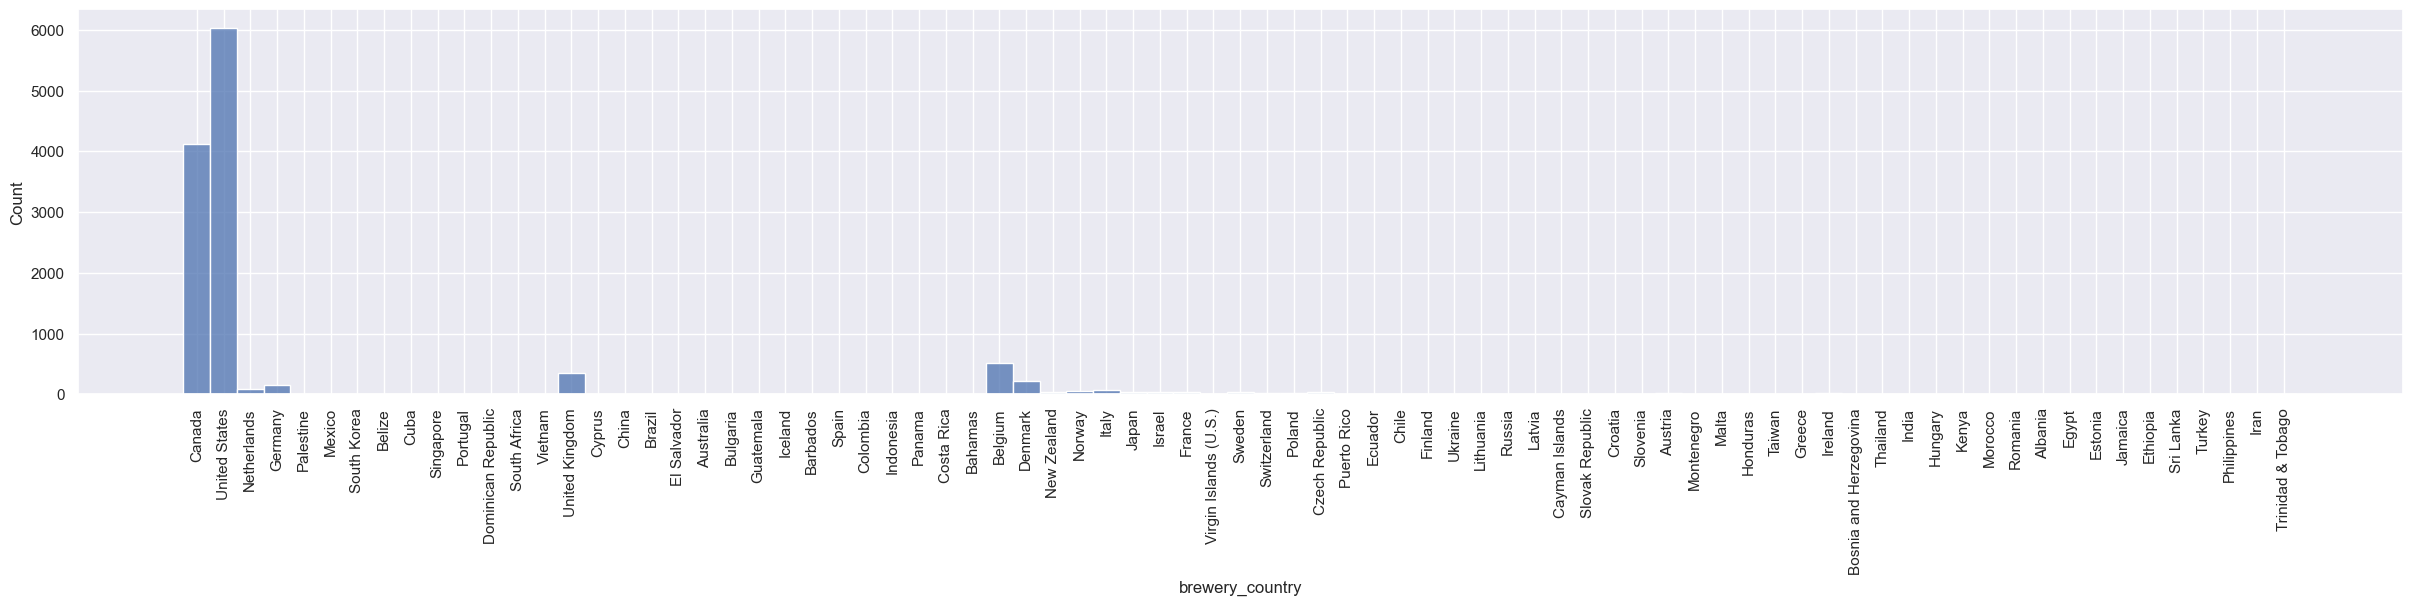

In [327]:
plt.figure(figsize=(30,5))
sns.histplot(data = df_ba_ratings_most_active_user, x = "brewery_country")
plt.xticks(rotation=90)
plt.show()

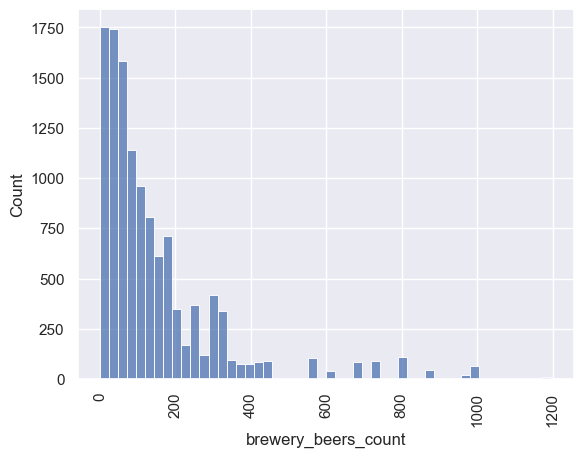

In [331]:
sns.histplot(data = df_ba_ratings_most_active_user, x = "brewery_beers_count", bins=50)
plt.xticks(rotation=90)
plt.show()

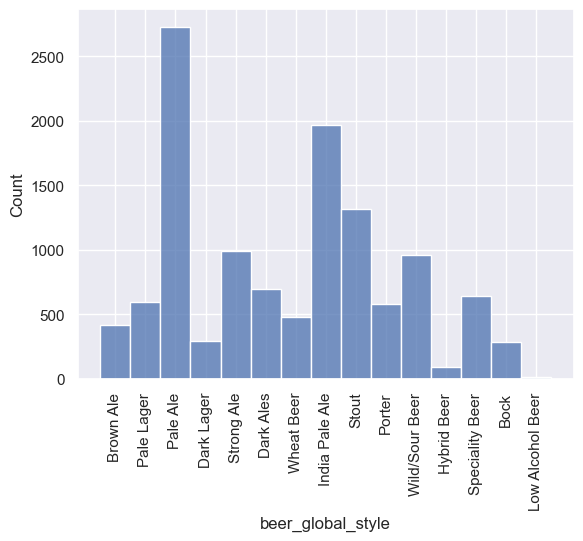

In [332]:
sns.histplot(data = df_ba_ratings_most_active_user, x = "beer_global_style")
plt.xticks(rotation=90)
plt.show()

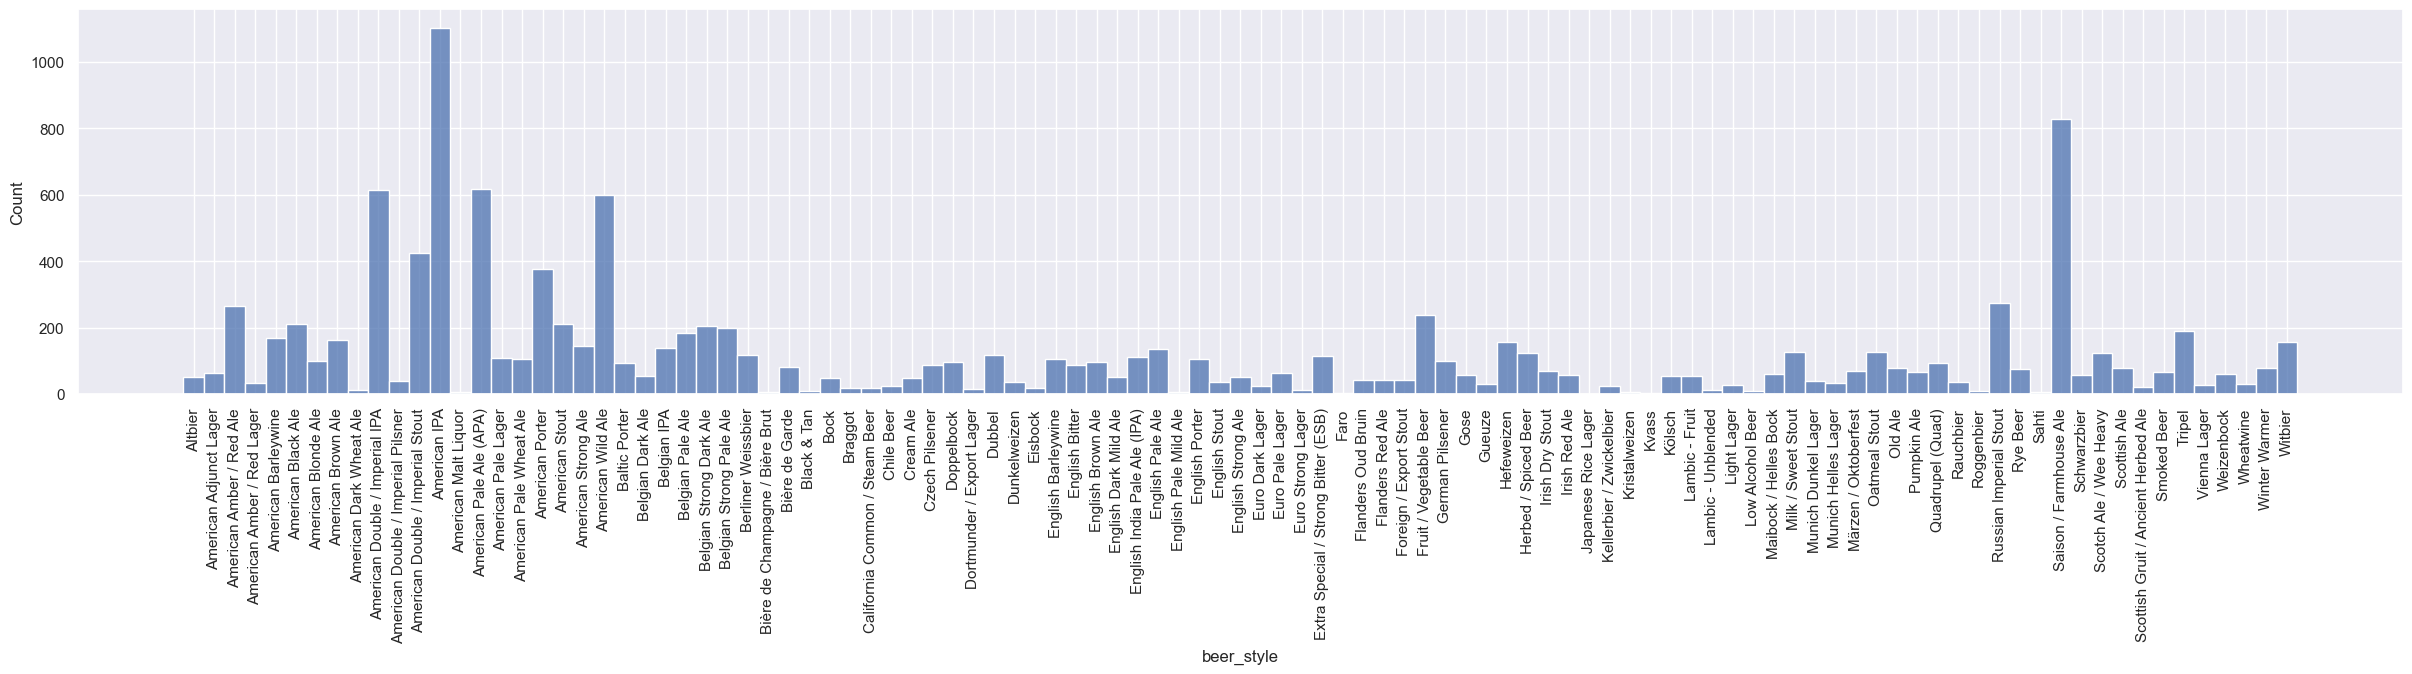

In [334]:
plt.figure(figsize=(30,5))
sns.histplot(data = df_ba_ratings_most_active_user, x = "beer_style")
plt.xticks(rotation=90)
plt.show()

In [ ]:
combined_gini = 1 - (df_ba_ratings_most_active_user[["beer_global_style","brewery_country"]].value_counts(normalize=True)**2).sum().item()
brewery_country_gini = 1 - (df_ba_ratings_most_active_user["brewery_country"].value_counts(normalize=True)**2).sum().item()
globa_style_gini = 1 - (df_ba_ratings_most_active_user["beer_global_style"].value_counts(normalize=True)**2).sum().item()
averaged_gini = (brewery_country_gini + globa_style_gini)/2

print(f"The combined Gini Index for both Brewery Country and Global Beer Style is {combined_gini}")
print(f"The Gini Index for Brewery Country is {combined_gini}")
print(f"The Gini Index for Global Beer Style is {globa_style_gini}")
print(f"The Averaged Gini Index for Brewery Country and Global Beer Style is {averaged_gini}")

In [345]:
def gini_index(series):
    proportions = series.value_counts(normalize=True)
    return 1 - (proportions ** 2).sum()

In [ ]:
df_ba_ratings_for_gini = df_ba_ratings[["user_id","beer_id","brewery_id"]].merge(df_ba_beers[["beer_id","beer_global_style"]],on="beer_id",how="inner").merge(df_ba_breweries[["brewery_id","brewery_country"]],on="brewery_id",how="inner")

gini_scores = df_ba_ratings_for_gini.groupby('user_id').apply(lambda user_df: pd.Series({
    'combined_gini': gini_index(user_df[["beer_global_style", "brewery_country"]].astype(str).agg('-'.join, axis=1)),
    'brewery_country_gini': gini_index(user_df['brewery_country']),
    'beer_global_style_gini': gini_index(user_df['beer_global_style']),
    'averaged_gini': (gini_index(user_df['brewery_country']) + gini_index(user_df['beer_global_style'])) / 2
})).reset_index()

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_47112/867752076.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gini_scores = df_ba_ratings_for_gini.groupby('user_id').apply(lambda user_df: pd.Series({


In [349]:
gini_scores.reset_index().sort_values(by="brewery_country_gini",ascending=False)

,user_id,combined_gini,brewery_country_gini,beer_global_style_gini,averaged_gini
91342,markonm.764007,0.987610,0.951660,0.751740,0.851700
86114,lelepat.820246,0.974921,0.925737,0.799773,0.862755
90913,marcrech.929578,0.958333,0.921667,0.810000,0.865833
150013,wilsonbaron.831512,0.980429,0.920958,0.774354,0.847656
48118,ernie.79195,0.964081,0.920792,0.667634,0.794213
...,...,...,...,...,...
63467,ihawk.1059252,0.444444,0.000000,0.444444,0.222222
63466,ihavemagicpants.815509,0.734694,0.000000,0.734694,0.367347
63464,ihaveajob.790782,0.000000,0.000000,0.000000,0.000000
63463,ihateutah.22484,0.000000,0.000000,0.000000,0.000000


# Beer Novice

## Quelle est la première bière ?

In [ ]:
df_first_beer = df_ba_ratings[df_ba_ratings["overall_past_ratings_count"] == 0].merge(df_ba_beers, on="beer_id", how="left")
df_first_beer["human_readable_date"] = pd.to_datetime(df_first_beer["date"], unit='s')
df_first_beer["year_month"] = df_first_beer['human_readable_date'].dt.strftime('%Y-%m')

In [297]:
df_first_beer.columns

Index(['user_id', 'beer_id', 'brewery_id_x', 'date', 'review', 'rating',
       'overall', 'aroma', 'appearance', 'palate', 'taste', 'text',
       'beer_style_x', 'user_created_date', 'overall_past_ratings_count',
       'style_past_ratings_count', 'past_ratings_average', 'rated_as_expert',
       'comparable_beer', 'brewery_id_y', 'beer_name', 'beer_style_y',
       'ratings_count', 'reviews_count', 'ratings_average', 'ratings_ba_score',
       'ratings_bros_score', 'beer_alcohol_by_volume',
       'ratings_average_computed', 'zscore', 'matching_ratings_count',
       'matching_ratings_average', 'beer_global_style', 'human_readable_date',
       'year_month'],
      dtype='object')

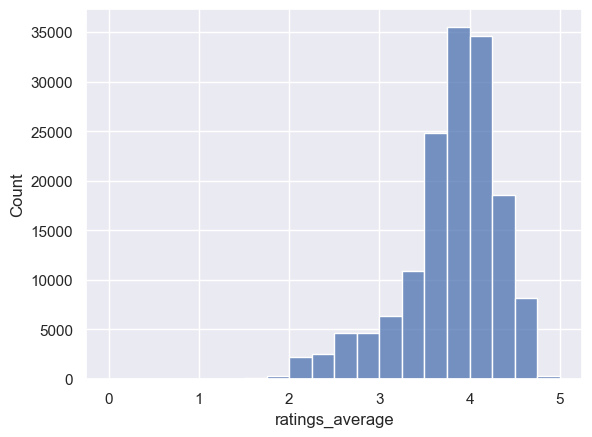

In [ ]:
sns.histplot(data=df_first_beer, x="ratings_average",bins=20) #À faire proprement en recalculant la moyenne de la bière avant la notation de l'utilisateur
plt.show()

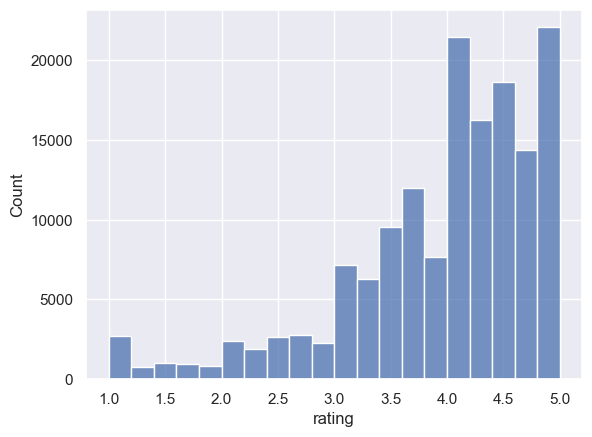

In [295]:
sns.histplot(data=df_first_beer, x="rating",bins=20)
plt.show()

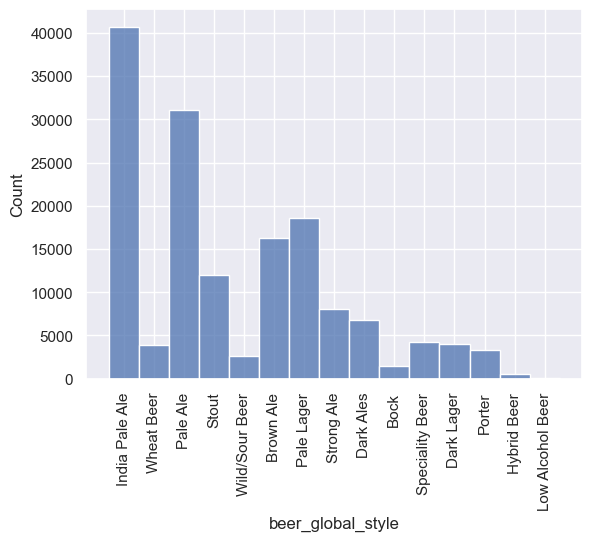

In [282]:
sns.histplot(data=df_first_beer,x="beer_global_style")
plt.xticks(rotation=90)
plt.show()

In [291]:
df_first_beer_temporal = df_first_beer[["beer_global_style","year_month","user_id"]].groupby(["beer_global_style","year_month"]).count().reset_index().sort_values(by="year_month",ascending=True)

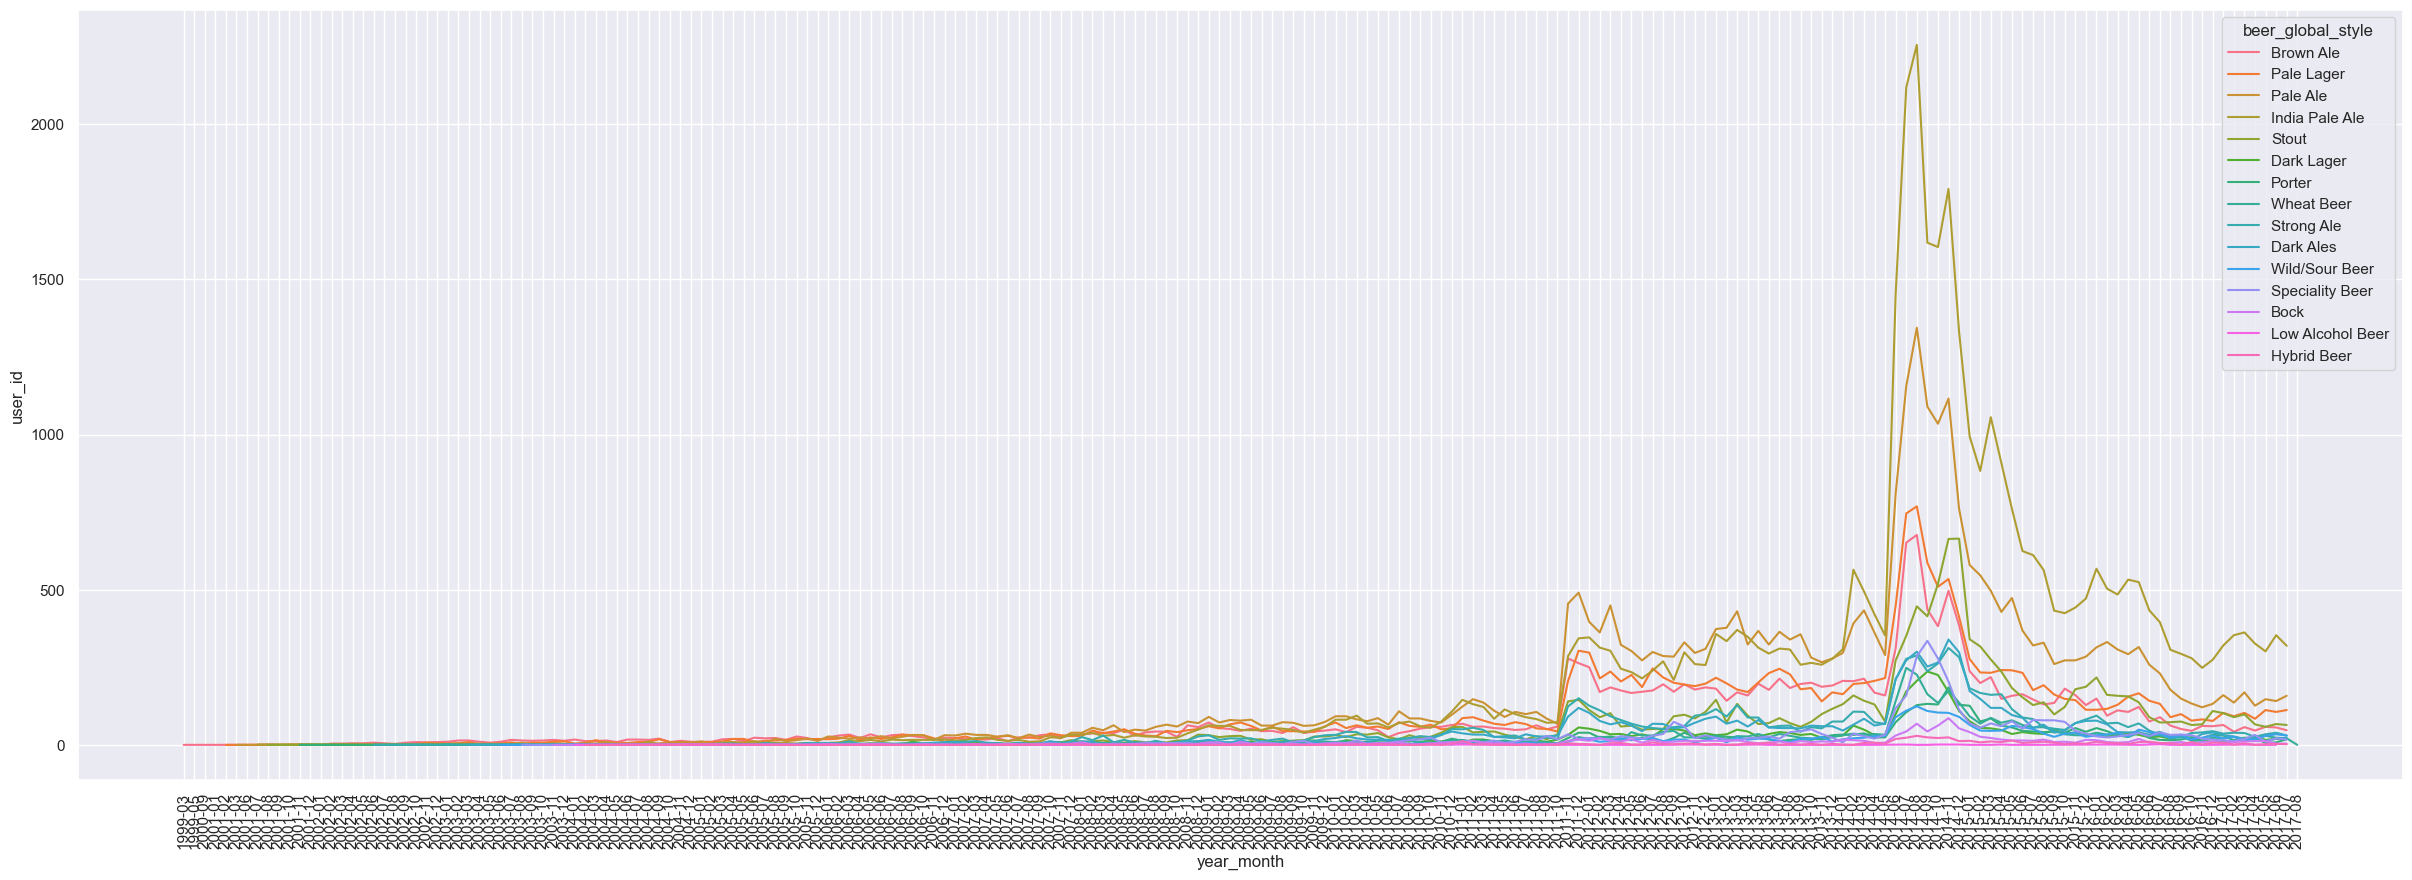

In [307]:
plt.figure(figsize=(30,10))
sns.lineplot(data = df_first_beer_temporal, x = "year_month", y = "user_id", hue = "beer_global_style")
plt.xticks(rotation=90)
plt.show()

## À quel point la moyenne influence les utilisateurs novices ?

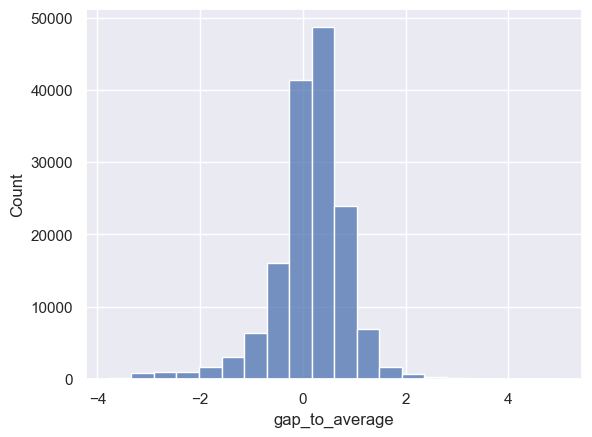

In [303]:
df_first_beer["gap_to_average"] = df_first_beer["rating"] - df_first_beer["ratings_average"] #À faire proprement en recalculant la moyenne de la bière avant la notation de l'utilisateur
sns.histplot(data=df_first_beer, x="gap_to_average",bins=20)
plt.show()

# Beer Enthusiast

In [119]:
median = df_ba_users["user_ratings_count"].quantile(0.5).item()
df_ba_users[df_ba_users["user_ratings_count"] >= median]

,user_ratings_count,user_reviews_count,user_id,user_name,user_created_date,user_country,user_region,user_country_code
0,7820,465,nmann08.184925,nmann08,1.199704e+09,United States,Washington,USA
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,United States,New York,USA
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,United Kingdom,Northern Ireland,GBR
3,31,31,helloloser12345.10867,helloloser12345,1.101380e+09,United Kingdom,Northern Ireland,GBR
4,604,604,cypressbob.3708,cypressbob,1.069326e+09,United Kingdom,Northern Ireland,GBR
...,...,...,...,...,...,...,...,...
153563,6,0,bwerme.877131,bwerme,1.413108e+09,NaN,NaN,NaN
153570,3,1,mheidenr44026.598439,mheidenr44026,1.305367e+09,United States,Ohio,USA
153638,5,0,pagail118.566707,pagail118,1.297595e+09,Canada,NaN,CAN
153661,8,0,lavuconn98.885443,Lavuconn98,1.414667e+09,NaN,NaN,NaN


## Analyse de subjectivité et sentiment

In [120]:
median = df_ba_users["user_ratings_count"].quantile(0.5).item()
enthusiasts = df_ba_users[df_ba_users["user_ratings_count"] >= median]["user_id"].to_list()

reviews_enthusiast = df_ba_ratings[(df_ba_ratings["review"] == True) & (df_ba_ratings["user_id"].isin(enthusiasts))]

In [121]:
reviews_enthusiast[(reviews_enthusiast["overall_past_ratings_count"] >= median) & (reviews_enthusiast["overall_past_ratings_count"] < df_ba_users["user_ratings_count"].quantile(0.99).item())] #Ratings with comments while being an enthusiast

,user_id,beer_id,brewery_id,date,review,rating,overall,aroma,appearance,palate,taste,text,beer_style,user_created_date,overall_past_ratings_count,style_past_ratings_count,past_ratings_average
2354455,--dom--.709199,35732,2743,1368266400,True,4.27,4.25,4.25,4.50,4.25,4.25,Poured from a bottle into a pint glass. Awesom...,American Amber / Red Ale,1.356174e+09,3,3,3.757895
6011457,--dom--.709199,1888,642,1418641200,True,4.50,NaN,NaN,NaN,NaN,NaN,A complete home run for Free State. Just an am...,American Barleywine,1.356174e+09,10,5,3.750000
5092994,--dom--.709199,146345,27870,1420196400,True,4.06,4.00,4.25,4.00,4.00,4.00,While I tend to only like beers over 6.5ish ab...,American Black Ale,1.356174e+09,11,0,3.696250
5304312,--dom--.709199,2093,64,1358074800,True,4.67,4.75,4.75,5.00,4.75,4.50,Poured from a 12 oz bottle into a snifter. Pou...,American Double / Imperial IPA,1.356174e+09,13,0,4.036000
4486754,--dom--.709199,14916,345,1358420400,True,4.24,4.25,4.50,4.75,4.25,4.00,Poured from a 12 oz bottle into a snifter. Pou...,American Double / Imperial IPA,1.356174e+09,14,1,4.272500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90095,zythus.301538,778,113,1242295200,True,5.00,5.00,5.00,5.00,5.00,5.00,Wow.Beer drinkers distinguished by candor and ...,Euro Pale Lager,1.235300e+09,4,0,3.927778
1836117,zythus.301538,40492,140,1237633200,True,4.03,4.00,3.00,3.50,5.00,4.50,12 fl. oz. of the 2009 SN ESB were poured into...,Extra Special / Strong Bitter (ESB),1.235300e+09,5,0,4.375000
289234,zythus.301538,3523,22,1241431200,True,2.86,3.00,2.00,3.00,4.00,3.00,"La Fin du Monde, of the same brewery, is one o...",Fruit / Vegetable Beer,1.235300e+09,6,0,3.546296
700928,zythus.301538,2412,428,1237633200,True,2.74,2.50,4.00,3.00,3.00,2.00,Beer pours from 1 pt .9 Fl.oz brown bottle int...,Kellerbier / Zwickelbier,1.235300e+09,7,0,3.824667


In [122]:
reviews_enthusiast.shape

(2563398, 17)

In [ ]:
reviews_enthusiast_country = reviews_enthusiast.merge(df_ba_users[["user_id","user_country","user_region"]],on="user_id",how="left")
reviews_enthusiast_country["user_country"].value_counts().reset_index().sort_values(by="count",ascending=False).head(20)

,user_country,count
0,United States,2219207
1,Canada,125803
2,United Kingdom,27038
3,Australia,25785
4,Netherlands,9709
5,Sweden,9012
6,Germany,8149
7,Spain,4092
8,Belgium,4012
9,Mexico,3788


In [125]:
reviews_enthusiast_country.groupby("user_country").count().reset_index().sort_values(by="review",ascending=False).head(20)

,user_country,user_id,beer_id,brewery_id,date,review,rating,overall,aroma,appearance,palate,taste,text,beer_style,user_created_date,overall_past_ratings_count,style_past_ratings_count,past_ratings_average,user_region
102,United States,2219207,2219207,2219207,2219207,2219207,2219207,2192988,2192988,2192988,2192988,2192988,2219205,2219207,2219207,2219207,2219207,2219206,2219207
23,Canada,125803,125803,125803,125803,125803,125803,124348,124348,124348,124348,124348,125803,125803,125803,125803,125803,125803,0
101,United Kingdom,27038,27038,27038,27038,27038,27038,26472,26472,26472,26472,26472,27038,27038,27038,27038,27038,27038,2143
7,Australia,25785,25785,25785,25785,25785,25785,25442,25442,25442,25442,25442,25785,25785,25785,25785,25785,25785,0
66,Netherlands,9709,9709,9709,9709,9709,9709,9559,9559,9559,9559,9559,9709,9709,9709,9709,9709,9709,0
89,Sweden,9012,9012,9012,9012,9012,9012,8939,8939,8939,8939,8939,9012,9012,9012,9012,9012,9012,0
37,Germany,8149,8149,8149,8149,8149,8149,8017,8017,8017,8017,8017,8149,8149,8149,8149,8149,8149,0
87,Spain,4092,4092,4092,4092,4092,4092,4024,4024,4024,4024,4024,4092,4092,4092,4092,4092,4092,0
12,Belgium,4012,4012,4012,4012,4012,4012,3995,3995,3995,3995,3995,4012,4012,4012,4012,4012,4012,0
64,Mexico,3788,3788,3788,3788,3788,3788,3782,3782,3782,3782,3782,3788,3788,3788,3788,3788,3788,0


# Beer Expert

## Combien de bières pour être un expert ?

Il faudrait essayer de définir si être un expert dépend uniquement du nombre de bières notées ou bien d'autres paramètres également (types de bières notées, diversité notées, diversité des notes données)

In [126]:
top_users = df_ba_users["user_ratings_count"].quantile(0.99).item()
df_ba_users[df_ba_users["user_ratings_count"] >= top_users]

,user_ratings_count,user_reviews_count,user_id,user_name,user_created_date,user_country,user_region,user_country_code
0,7820,465,nmann08.184925,nmann08,1.199704e+09,United States,Washington,USA
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,United States,New York,USA
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,United Kingdom,Northern Ireland,GBR
5,2326,0,hellpop65.48993,Hellpop65,1.131966e+09,United States,Kansas,USA
6,3098,0,latarnik.52897,Latarnik,1.133521e+09,United States,New Jersey,USA
...,...,...,...,...,...,...,...,...
30610,1331,0,italianstallion.788089,italianstallion,1.394622e+09,United States,Wisconsin,USA
32690,1261,1017,ri0.683063,Ri0,1.341137e+09,United States,Wisconsin,USA
32760,1219,5,xdtfx.691499,xdtfx,1.346062e+09,United States,Illinois,USA
40813,1039,542,mikeward.620428,MikeWard,1.315994e+09,United States,Pennsylvania,USA


## Comment notent les experts ?

Pour comparer la notation des experts à celles des autres utilisateurs, il faut faire la supposition que la qualité et le goût des bières ne changent pas avec le temps sinon cela rendrait impossible des comparaisons à dates trop différentes

In [128]:
df_ba_users["beers_as_expert"] = df_ba_users["user_ratings_count"] - top_users

In [135]:
df_ba_users[(df_ba_users["user_ratings_count"] >= top_users) & (df_ba_users["beers_as_expert"] > 0)].sort_values(by="beers_as_expert").head()

,user_ratings_count,user_reviews_count,user_id,user_name,user_created_date,user_country,user_region,user_country_code,beers_as_expert
1119,1024,0,trickkygangsta.640751,TrickkyGangsta,1.323169e+09,United States,Florida,USA,1.0
2762,1024,1005,ricks95.5391,RickS95,1.079694e+09,United States,Indiana,USA,1.0
1337,1024,106,futbolmanby.1010699,Futbolmanby,1.436263e+09,United States,Michigan,USA,1.0
1823,1025,1024,kingcrowing.311556,kingcrowing,1.237892e+09,United States,Vermont,USA,2.0
4769,1026,0,chrispoint.381778,chrispoint,1.255514e+09,United States,Connecticut,USA,3.0


In [136]:
df_ba_users[(df_ba_users["user_ratings_count"] >= top_users) & (df_ba_users["beers_as_expert"] > 0)].sort_values(by="beers_as_expert").tail()

,user_ratings_count,user_reviews_count,user_id,user_name,user_created_date,user_country,user_region,user_country_code,beers_as_expert
994,9991,1122,grg1313.288024,GRG1313,1.232017e+09,United States,California,USA,8968.0
969,10180,2091,kylehay2004.571365,kylehay2004,1.298459e+09,United States,Illinois,USA,9157.0
1583,10302,34,texasfan549.572853,Texasfan549,1.298718e+09,United States,Texas,USA,9279.0
1352,10360,66,acurtis.508168,acurtis,1.285582e+09,United States,New Jersey,USA,9337.0
228,12046,7593,sammy.3853,Sammy,1.070276e+09,Canada,NaN,CAN,11023.0


In [149]:
experts = df_ba_users[df_ba_users["user_ratings_count"] >= top_users]["user_id"].tolist()
df_ba_ratings["rated_as_expert"] = ((df_ba_ratings["user_id"].isin(experts)) & (df_ba_ratings["overall_past_ratings_count"] > top_users))

In [151]:
df_ba_ratings[df_ba_ratings["rated_as_expert"] == True]

,user_id,beer_id,brewery_id,date,review,rating,overall,aroma,appearance,palate,taste,text,beer_style,user_created_date,overall_past_ratings_count,style_past_ratings_count,past_ratings_average,rated_as_expert
5191251,1sundown2c.654530,110631,32319,1432807200,False,3.15,3.00,3.50,3.50,3.00,3.00,Way too woody/papery. Tastes like an old book,Saison / Farmhouse Ale,1.326452e+09,1024,21,3.575000,True
3726973,1sundown2c.654530,184672,33510,1439632800,False,3.75,3.75,3.75,3.75,3.75,3.75,NaN,Saison / Farmhouse Ale,1.326452e+09,1025,22,3.901552,True
7368221,1sundown2c.654530,173487,24018,1439719200,False,4.25,4.25,4.25,4.25,4.25,4.25,NaN,Saison / Farmhouse Ale,1.326452e+09,1026,23,3.500000,True
3161484,1sundown2c.654530,185243,30654,1444557600,False,3.75,3.75,3.75,3.75,3.75,3.75,NaN,Saison / Farmhouse Ale,1.326452e+09,1027,24,3.250000,True
5977595,1sundown2c.654530,167155,24903,1446894000,False,3.75,3.75,3.75,3.75,3.75,3.75,NaN,Saison / Farmhouse Ale,1.326452e+09,1028,25,3.250000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5098516,zuidman.587717,146443,27870,1433844000,False,3.68,3.75,3.50,3.50,3.75,3.75,NaN,Witbier,1.301566e+09,2103,12,4.039412,True
5176233,zuidman.587717,124633,25888,1448794800,False,3.75,3.75,3.75,3.75,3.75,3.75,NaN,Witbier,1.301566e+09,2104,13,2.760000,True
2165979,zuidman.587717,224133,21092,1468404000,False,3.73,3.75,3.75,3.75,3.50,3.75,NaN,Witbier,1.301566e+09,2105,14,4.980000,True
2419607,zuidman.587717,222187,147,1473069600,False,3.00,3.00,3.00,3.00,3.00,3.00,NaN,Witbier,1.301566e+09,2106,15,4.195000,True


In [ ]:
df_comparable_beer = (df_ba_ratings.groupby("beer_id")["rated_as_expert"].nunique() == 2).reset_index().rename(columns={"rated_as_expert":"comparable_beer"})
df_ba_ratings = df_ba_ratings.merge(df_comparable_beer,on="beer_id",how="left")

df_ratings_comparison = df_ba_ratings[df_ba_ratings["comparable_beer"] == True][["rated_as_expert","rating","overall","aroma","appearance","palate","taste","beer_id"]].groupby(["beer_id","rated_as_expert"]).mean().reset_index()
df_expert_comparison = df_ratings_comparison[df_ratings_comparison["rated_as_expert"] == True].merge(df_ratings_comparison[df_ratings_comparison["rated_as_expert"] == False],on="beer_id",how="inner",suffixes=["_expert","_regular"])

In [229]:
columns_to_compare = ["rating","overall","aroma","appearance","palate","taste"]
for column in columns_to_compare:
    df_expert_comparison[f"{column}_mean_gap"] = df_expert_comparison[f"{column}_expert"] - df_expert_comparison[f"{column}_regular"]

In [246]:
df_expert_comparison[["beer_id"]+[f"{column}_mean_gap" for column in columns_to_compare]].sort_values(by="rating_mean_gap")

,beer_id,rating_mean_gap,overall_mean_gap,aroma_mean_gap,appearance_mean_gap,palate_mean_gap,taste_mean_gap
65420,135587,-3.905000,NaN,NaN,NaN,NaN,NaN
67351,139991,-3.550000,-3.000000,-3.000000,-3.00,-3.000000,-3.000
25891,59098,-3.520000,-3.500000,-4.000000,-1.00,-2.000000,-4.000
63873,132040,-3.317857,-3.916667,-3.958333,-3.75,-3.541667,-3.875
36279,79296,-3.300000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
69146,144589,2.910000,NaN,NaN,NaN,NaN,NaN
69653,145868,2.960000,NaN,NaN,NaN,NaN,NaN
28367,64229,3.000000,NaN,NaN,NaN,NaN,NaN
20343,47405,3.050000,NaN,NaN,NaN,NaN,NaN
